In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### load packages

In [4]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [6]:
dataset = 'cassins'
dims = (32,32,1)
n_components = 2

In [7]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

syllable_df = pd.read_pickle(DATA_DIR/'cassins'/ 'cassins.pickle')



top_labels = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.labels.values == i)] for i in syllable_df.labels.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:20]
    .T
)

syllable_df = syllable_df[syllable_df.labels.isin(top_labels.columns)]

syllable_df[:3]
syllable_df = syllable_df.reset_index()

syllable_df['subset'] = 'train'
syllable_df.loc[:1000, 'subset'] = 'valid'
syllable_df.loc[1000:1999, 'subset'] = 'test'

specs = np.array(list(syllable_df.spectrogram.values))
specs = np.array([np.concatenate([np.zeros((32,1)), i], axis=1) for i in tqdm(specs)])


syllable_df['spectrogram'] = syllable_df['spectrogram'].astype('object')
syllable_df['spectrogram'] = list(specs)


Y_train = np.array(list(syllable_df.labels.values[syllable_df.subset == 'train']))
Y_valid = np.array(list(syllable_df.labels.values[syllable_df.subset == 'valid']))
Y_test = np.array(list(syllable_df.labels.values[syllable_df.subset == 'test']))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

X_train = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'train'])) #/ 255.
X_valid = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'valid']))# / 255.
X_test = np.array(list(syllable_df.spectrogram.values[syllable_df.subset == 'test'])) #/ 255.

X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
Y_train = enc.fit_transform([[i] for i in Y_train]).astype('int').flatten()
Y_test = enc.fit_transform([[i] for i in Y_test]).astype('int').flatten()

### define networks

In [8]:
from tensorflow.keras.layers import (
    Conv2D,
    Reshape,
    Bidirectional,
    Dense,
    RepeatVector,
    TimeDistributed,
    LSTM
)
n_components=2

In [9]:
from tfumap.vae import VAE, Sampling

In [10]:

encoder_inputs = tf.keras.Input(shape=dims)
x = Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu, padding="same"
    )(encoder_inputs)
x = Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation=tf.nn.leaky_relu, padding="same"
    )(x)
x = Conv2D(
        filters=128, kernel_size=3, strides=(2, 1), activation=tf.nn.leaky_relu, padding="same"
    )(x)
x = Conv2D(
        filters=128, kernel_size=3, strides=(2, 1), activation=tf.nn.leaky_relu, padding="same"
    )(x)
x = Reshape(target_shape=(8, 2*128))(x)
x = Bidirectional(LSTM(units=100, activation="relu"))(x)
x = Dense(units=512)(x)
z_mean = tf.keras.layers.Dense(n_components, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(n_components, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

W0821 21:57:43.868546 140064909145920 recurrent_v2.py:1098] Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
W0821 21:57:43.874493 140064909145920 recurrent_v2.py:1098] Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
W0821 21:57:43.882551 140064909145920 recurrent_v2.py:1098] Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 4, 8, 128)    73856       conv2d_1[0][0]                   
____________________________________________________________________________________________

In [11]:
latent_inputs = tf.keras.Input(shape=(n_components,))
x = Dense(units=512)(latent_inputs)
x = RepeatVector(8)(x)
x = Bidirectional(LSTM(units=100, activation="relu", return_sequences=True))(x)
x = TimeDistributed(Dense(2*128))(x)
x = Reshape(target_shape=(8,2,128))(x)
x = tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(1, 2), padding="SAME", activation=tf.nn.leaky_relu
    )(x)

x = tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(1, 2), padding="SAME", activation=tf.nn.leaky_relu
    )(x)
x = tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    )(x)
x = tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation=tf.nn.leaky_relu
    )(x)
x = tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="tanh"
    )(x)


decoder_outputs = Reshape(target_shape=(32, 32, 1))(x)
decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


W0821 21:57:47.039870 140064909145920 recurrent_v2.py:1098] Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
W0821 21:57:47.045707 140064909145920 recurrent_v2.py:1098] Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU
W0821 21:57:47.061730 140064909145920 recurrent_v2.py:1098] Layer lstm_1 will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1536      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 8, 512)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 8, 200)            490400    
_________________________________________________________________
time_distributed (TimeDistri (None, 8, 256)            51456     
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 2, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 4, 128)         1475

### Create model and train

In [12]:
X_train.shape

(24984, 32, 32)

In [13]:
X_train = X_train.reshape([len(X_train)]+ list(dims))
X_train.shape

(24984, 32, 32, 1)

In [14]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [15]:
vae.fit(X_train, epochs=30, batch_size=128)

Epoch 1/30
196/196 [==============================] - 14s 69ms/step - loss: 128.8258 - reconstruction_loss: 128.1817 - kl_loss: 0.6441
Epoch 2/30
196/196 [==============================] - 13s 67ms/step - loss: 114.9055 - reconstruction_loss: 113.2512 - kl_loss: 1.6544
Epoch 3/30
196/196 [==============================] - 14s 71ms/step - loss: 102.0810 - reconstruction_loss: 100.3682 - kl_loss: 1.7128
Epoch 4/30
196/196 [==============================] - 14s 70ms/step - loss: 100.3899 - reconstruction_loss: 98.7607 - kl_loss: 1.6292
Epoch 5/30
196/196 [==============================] - 13s 64ms/step - loss: 98.7444 - reconstruction_loss: 97.0584 - kl_loss: 1.6860
Epoch 6/30
196/196 [==============================] - 14s 70ms/step - loss: 105.6986 - reconstruction_loss: 104.1798 - kl_loss: 1.5187
Epoch 7/30
196/196 [==============================] - 13s 66ms/step - loss: 102.7891 - reconstruction_loss: 101.1793 - kl_loss: 1.6098
Epoch 8/30
196/196 [==============================] - 12s 

In [16]:
z = vae.encoder.predict(X_train)[0]

### Plot model output

In [17]:
Y_train

array([14, 11, 11, ...,  6,  0,  0])

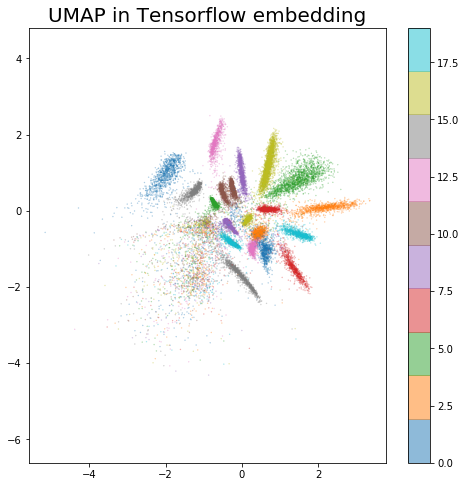

In [18]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)].flatten(),
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [19]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

### Save output

In [20]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [72]:
dataset = "cassins_dtw"

In [73]:
output_dir = MODEL_DIR/'projections'/ dataset / 'vae'
ensure_dir(output_dir)

In [74]:
#vae.save(output_dir)

In [75]:
vae.encoder.save(output_dir / 'encoder')

I0821 22:39:27.978430 140064909145920 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cassins_dtw/vae/encoder/assets


In [76]:
vae.decoder.save(output_dir / 'encoder')

I0821 22:39:33.092087 140064909145920 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/cassins_dtw/vae/encoder/assets


In [77]:
#loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [78]:
np.save(output_dir / 'z.npy', z)

### compute metrics 

In [79]:
X_test.shape

(1000, 32, 32)

In [80]:
z_test = encoder.predict(X_test.reshape((len(X_test), 32,32,1)))[0]

#### silhouette

In [81]:
from tfumap.silhouette import silhouette_score_block

In [82]:
ss, sil_samp = silhouette_score_block(z, Y_train, n_jobs = -1)
ss

0.23461243719215408

In [83]:
ss_test, sil_samp_test = silhouette_score_block(z_test, Y_test, n_jobs = -1)
ss_test

0.31252578525792846

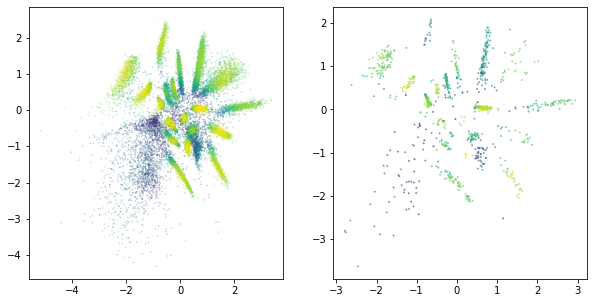

In [84]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=sil_samp, cmap=plt.cm.viridis)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=sil_samp_test, cmap=plt.cm.viridis)

#### KNN

In [85]:
from sklearn.neighbors import KNeighborsClassifier

In [86]:
z

array([[-0.1131468 , -1.5806428 ],
       [-1.388152  , -0.6878314 ],
       [-0.9453604 , -0.31103107],
       ...,
       [ 1.5438435 , -1.7073576 ],
       [-1.5385633 ,  1.2321515 ],
       [-1.6765001 ,  1.1187935 ]], dtype=float32)

In [87]:
z_test

array([[ 0.6573393 ,  1.2295736 ],
       [ 2.5263803 ,  0.20086958],
       [ 0.3846845 , -0.6861006 ],
       ...,
       [ 0.07778246,  0.7015703 ],
       [-0.1457613 , -1.6066463 ],
       [-0.00800747,  0.71712905]], dtype=float32)

In [88]:
Y_train

array([14, 11, 11, ...,  6,  0,  0])

In [89]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(z, Y_train)
score_5nn = neigh5.score(z_test, Y_test)
score_5nn

0.935

In [90]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(z, Y_train)
score_1nn = neigh1.score(z_test, Y_test)
score_1nn

0.913

#### Trustworthiness

In [91]:
from sklearn.manifold import trustworthiness

In [92]:
tw = trustworthiness(X_train_flat[:10000], z[:10000])

In [93]:
tw_test = trustworthiness(X_test_flat[:10000], z_test[:10000])

In [94]:
tw, tw_test

(0.9526700680544435, 0.9672012096774194)

### Save output metrics

In [95]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

#### train

In [96]:
metrics_df = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df.loc[len(metrics_df)] = [dataset, 'vae', n_components, tw, ss, sil_samp]
metrics_df

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
0,cassins_dtw,vae,2,0.95267,0.234612,"[0.42276681270352584, -0.22088905441034784, -0..."


In [97]:
save_loc = DATA_DIR / 'projection_metrics' /  'vae' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)
save_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/data/projection_metrics/vae/train/2/cassins_dtw.pickle')

#### test

In [98]:
metrics_df_test = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df_test.loc[len(metrics_df)] = [dataset, 'vae', n_components, tw_test, ss_test, sil_samp_test]
metrics_df_test

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
1,cassins_dtw,vae,2,0.967201,0.312526,"[0.13769674966963893, 0.43184719745642103, 0.2..."


In [99]:
save_loc = DATA_DIR / 'projection_metrics' / 'vae' / 'test' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### knn 

In [100]:
nn_acc_df = pd.DataFrame(columns = ["method_","dimensions","dataset","1NN_acc","5NN_acc"])
nn_acc_df.loc[len(nn_acc_df)] = ['vae', n_components, dataset,  score_1nn, score_5nn]
nn_acc_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,vae,2,cassins_dtw,0.913,0.935


In [101]:
save_loc = DATA_DIR / 'knn_classifier' / 'vae' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
nn_acc_df.to_pickle(save_loc)

### Reconstruction

In [102]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

In [103]:
X_recon = vae.decoder.predict(vae.encoder.predict(X_test.reshape((len(X_test), 32, 32, 1)))[0])
X_real = X_test.reshape((len(X_test), 32, 32, 1))

In [104]:
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

In [105]:
reconstruction_acc_df = pd.DataFrame(
    columns=["method_", "dimensions", "dataset", "MSE", "MAE", "MedAE", "R2"]
)

In [106]:
MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['vae', 2, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,vae,2,cassins_dtw,0.004813,0.037265,0.02717,-1.001968e+09


In [107]:
save_loc = DATA_DIR / 'reconstruction_acc' / 'vae' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
reconstruction_acc_df.to_pickle(save_loc)

### Compute clustering quality

In [108]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure

In [109]:
def get_cluster_metrics(row, n_init=5):
    
    # load cluster information
    save_loc = DATA_DIR / 'clustering_metric_df'/ ('_'.join([row.class_, str(row.dim), row.dataset]) + '.pickle')
    print(save_loc)
    if save_loc.exists() and save_loc.is_file():
        
        cluster_df = pd.read_pickle(save_loc)
        return cluster_df
    
    # make cluster metric dataframe
    cluster_df = pd.DataFrame(
        columns=[
            "dataset",
            "class_",
            "dim",
            "silhouette",
            "homogeneity",
            "completeness",
            "v_measure",
            "init_",
            "n_clusters",
            "model",
        ]
    )
    y = row.train_label
    z = row.train_z
    n_labels = len(np.unique(y))
    for n_clusters in tqdm(np.arange(n_labels - int(n_labels / 2), n_labels + int(n_labels / 2)), leave=False, desc = 'n_clusters'):
        for init_ in tqdm(range(n_init), leave=False, desc='init'):
            kmeans = KMeans(n_clusters=n_clusters, random_state=init_).fit(z)
            clustered_y = kmeans.labels_
            homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(
                y, clustered_y
            )
            ss, _ = silhouette_score_block(z, clustered_y)
            cluster_df.loc[len(cluster_df)] = [
                row.dataset,
                row.class_,
                row.dim,
                ss,
                homogeneity,
                completeness,
                v_measure,
                init_,
                n_clusters,
                kmeans,
            ]
    
     # save cluster df in case this fails somewhere
    ensure_dir(save_loc)
    cluster_df.to_pickle(save_loc)
    return cluster_df

In [110]:
projection_df = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label', 'dim'])
projection_df.loc[len(projection_df)] = [dataset, 'vae', z, Y_train.flatten(), n_components]
projection_df

,dataset,class_,train_z,train_label,dim
0,cassins_dtw,vae,"[[-0.1131468, -1.5806428], [-1.388152, -0.6878...","[14, 11, 11, 11, 11, 11, 11, 11, 11, 17, 0, 0,...",2


In [111]:
get_cluster_metrics(projection_df.iloc[0], n_init=5)

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/data/clustering_metric_df/vae_2_cassins_dtw.pickle


,dataset,class_,dim,silhouette,homogeneity,completeness,v_measure,init_,n_clusters,model
0,cassins_dtw,vae,2,0.430460,0.547627,0.725097,0.623989,0,10,"KMeans(n_clusters=10, random_state=0)"
1,cassins_dtw,vae,2,0.430512,0.547659,0.725154,0.624030,1,10,"KMeans(n_clusters=10, random_state=1)"
2,cassins_dtw,vae,2,0.430663,0.548218,0.725687,0.624590,2,10,"KMeans(n_clusters=10, random_state=2)"
3,cassins_dtw,vae,2,0.430810,0.548317,0.725872,0.624724,3,10,"KMeans(n_clusters=10, random_state=3)"
4,cassins_dtw,vae,2,0.430808,0.548653,0.726384,0.625131,4,10,"KMeans(n_clusters=10, random_state=4)"
...,...,...,...,...,...,...,...,...,...,...
95,cassins_dtw,vae,2,0.490053,0.761213,0.700749,0.729730,0,29,"KMeans(n_clusters=29, random_state=0)"
96,cassins_dtw,vae,2,0.493268,0.765380,0.695822,0.728946,1,29,"KMeans(n_clusters=29, random_state=1)"
97,cassins_dtw,vae,2,0.490244,0.774395,0.699230,0.734895,2,29,"KMeans(n_clusters=29, random_state=2)"
98,cassins_dtw,vae,2,0.500171,0.775008,0.704105,0.737857,3,29,"KMeans(n_clusters=29, random_state=3)"


In [112]:
z_test.shape

(1000, 2)